<center><span style="font-family:Comic Sans MS; color:navy "><h1>Binary Classification with a Bank Churn Dataset</h1></span></center>

# <b>a <span style='color:#94D4F6'>|</span> Table of Conents</b>
<a id="toc"></a>
- [1. Import Libraries](#1)
- [2. Read Dataset](#2)
- [3. Visualization](#3)
- [4. Preprocessing](#4)
- [6. Split Dataset](#6)
- [7. Modeling](#7)
- [9. Evaluation](#8) 
- [8. Predict test data](#9)

# <b>b <span style='color:#94D4F6'>|</span> About DataSet</b>

<div class="alert alert-block alert-info" style="font-size:17px; background-color: #EEEFFF; font-family:Comic Sans MS; color: #00011A; border: 1px #00011A">
The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:
    

**Customer ID:** A unique identifier for each customer
    
**Surname:** The customer's surname or last name
    
**Credit Score:** A numerical value representing the customer's credit score
    
**Geography:** The country where the customer resides (France, Spain or Germany)
    
**Gender:** The customer's gender (Male or Female)
    
**Age:** The customer's age.
    
**Tenure:** The number of years the customer has been with the bank
    
**Balance:** The customer's account balance
    
**NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
    
**HasCrCard:** Whether the customer has a credit card (1 = yes, 0 = no)

**IsActiveMember:** Whether the customer is an active member (1 = yes, 0 = no)
    
**EstimatedSalary:** The estimated salary of the customer
    
**Exited:** Whether the customer has churned (1 = yes, 0 = no)

<a id="1"></a>
# <b>1 <span style='color:#94D4F6'>|</span> Import Libraries</b>

In [1]:
import numpy as np # for calculation
import pandas as pd # for work with Dataset

# for Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# PreProcessing
from sklearn.model_selection import(
    train_test_split,# used to split the data into training and testing
    cross_val_score,
)

# Modeling
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier


# For Evaluation 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<a id="2"></a>
# <b>2 <span style='color:#94D4F6'>|</span> Read Dataset</b>

In [ ]:
# main dataset as df
# test datset as test
# sample_submission dataset as ss
# original dataset as od
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
ss = pd.read_csv('./Data/sample_submission.csv')
od = pd.read_csv('./Data/Churn_Modelling.csv')

In [ ]:
df.head()

In [ ]:
od.head()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


<div class="alert alert-block alert-info" style="font-size:17px; background-color: #EEEFFF; font-family:Comic Sans MS; color: #00011A; border: 1px #00011A">
Here, we have 14 columns with different data types, including both categorical and numerical variables. and as you can see, our dataset does not contain any null values. However, We need to perform preprocessing operations on these variables to transform them into suitable inputs for our modeling step.

### Shape

In [27]:
print('shape of training dataset:')
print('there are {} rows and {} columns in training dataset.'.format(df.shape[0],df.shape[1]))
print('shape of test dataset:')
print('there are {} rows and {} columns in test dataset.'.format(test.shape[0],test.shape[1]))
print('shape of original dataset:')
print('there are {} rows and {} columns original dataset.'.format(od.shape[0],od.shape[1]))

shape of training dataset:
there are 165034 rows and 14 columns in training dataset.
shape of test dataset:
there are 110023 rows and 13 columns in test dataset.
shape of original dataset:
there are 10002 rows and 14 columns original dataset.


### Describe the dataset

In [28]:
df.describe().style.background_gradient(cmap = 'inferno')

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.500000,15692005.019026,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.356500,71397.816791,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.250000,15633141.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.500000,15690169.000000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.750000,15756824.000000,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


<div class="alert alert-block alert-info" style="font-size:17px; background-color: #EEEFFF; font-family:Comic Sans MS; color: #00011A; border: 1px #00011A">
And here is some statistical information about our dataset. I will create clear plots to present the data more effectively.

### Columns

In [29]:
df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### Drop ID&Surname columns

In [30]:
testID = test['id']
df.drop(['id', 'Surname'],axis=1,inplace=True)
od.drop(['RowNumber','Surname'],axis = 1, inplace = True)
test.drop(['id', 'Surname'],axis = 1,inplace =True)

<div class="alert alert-block alert-info" style="font-size:17px; background-color: #EEEFFF; font-family:Comic Sans MS; color: #00011A; border: 1px #00011A">
Here, I should identify if there is any similarity between the dataset ID and customer ID. In the previous statement, I mentioned that I dropped the dataset or row number, but I meant to say that I did not drop the customer ID. The customer ID is a unique identifier for each customer, and it is a valuable column for our analysis.

### Determine the Categorical and Numerical Features

In [31]:
target = 'Exited'
obj_col = [x for x in df.select_dtypes(include=['object']).columns if x!=target]
num_col = [x for x in df.select_dtypes(exclude =['object']).columns if x!= target]
print(f'obj_columns: {obj_col}')
print(f'num_columns: {num_col}')

obj_columns: ['Geography', 'Gender']
num_columns: ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


<a id="3"></a>
# <b>3 <span style='color:#94D4F6'>|</span> Explanatory Data Analysis (EDA)</b>

<font size="3">Let's see what's the quality of raw dataset.</font>

In [32]:
def summary(df):
    sum = pd.DataFrame(df.dtypes,columns = ['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['unique'] =  df.nunique().values
    sum['count'] = df.count().values
    return sum
summary(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,unique,count
CustomerId,int64,0,0.000000,23221,165034
CreditScore,int64,0,0.000000,457,165034
Geography,object,0,0.000000,3,165034
Gender,object,0,0.000000,2,165034
Age,float64,0,0.000000,71,165034
Tenure,int64,0,0.000000,11,165034
Balance,float64,0,0.000000,30075,165034
NumOfProducts,int64,0,0.000000,4,165034
HasCrCard,float64,0,0.000000,2,165034
IsActiveMember,float64,0,0.000000,2,165034


In [33]:
print('----------test data ------------')
summary(test).style.background_gradient(cmap='Blues')

----------test data ------------


,dtypes,missing#,missing%,unique,count
CustomerId,int64,0,0.000000,19698,110023
CreditScore,int64,0,0.000000,454,110023
Geography,object,0,0.000000,3,110023
Gender,object,0,0.000000,2,110023
Age,float64,0,0.000000,74,110023
Tenure,int64,0,0.000000,11,110023
Balance,float64,0,0.000000,22513,110023
NumOfProducts,int64,0,0.000000,4,110023
HasCrCard,float64,0,0.000000,2,110023
IsActiveMember,float64,0,0.000000,2,110023


### Checking Correlation 

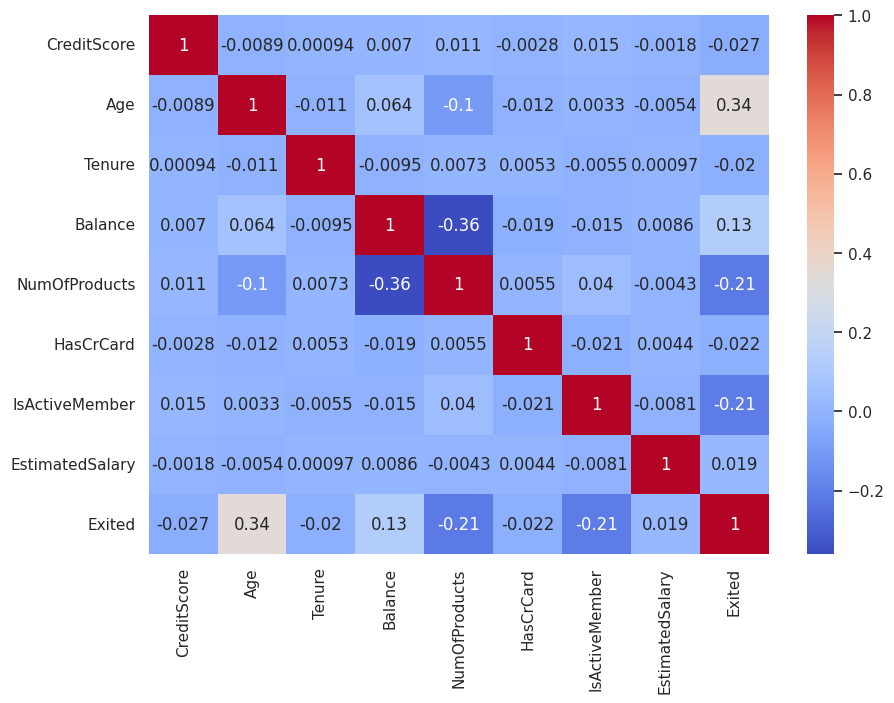

In [34]:
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
data = df[columns]
correlation_matrix = data.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

<div class="alert alert-block alert-info" style="font-size:17px; background-color: #EEEFFF; font-family:Comic Sans MS; color: #00011A; border: 1px #00011A">
    
-  The values inside each cell represent the correlation coefficient, which ranges from -1 to 1. A correlation coefficient of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation between the variables.
    
- The diagonal line from the top-left to the bottom-right of the heatmap represents the correlation of each variable with itself, which is always 1. These values are not informative for analysis.
    
- The upper and lower triangular portions of the heatmap are mirror images of each other since the correlation matrix is symmetric.

### Label Distribution

Count of each Status:
Exited
0    130113
1     34921
Name: count, dtype: int64
----------------------------------------------------------



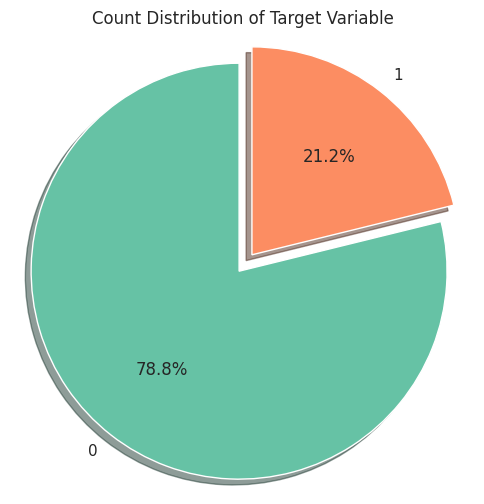

In [35]:
counts = df['Exited'].value_counts()
df_counts = pd.DataFrame({'Class': counts.index, 'Count': counts.values})
print("Count of each Status:")
print(counts)
print("----------------------------------------------------------")
print()


sns.set_palette("Set2")
plt.figure(figsize=(6, 6))
plt.pie(df_counts['Count'], labels=df_counts['Class'], autopct='%1.1f%%',explode=(0.05,0.05), shadow=True, startangle=90, colors=sns.color_palette())
plt.title('Count Distribution of Target Variable')
plt.axis('equal')
plt.show()

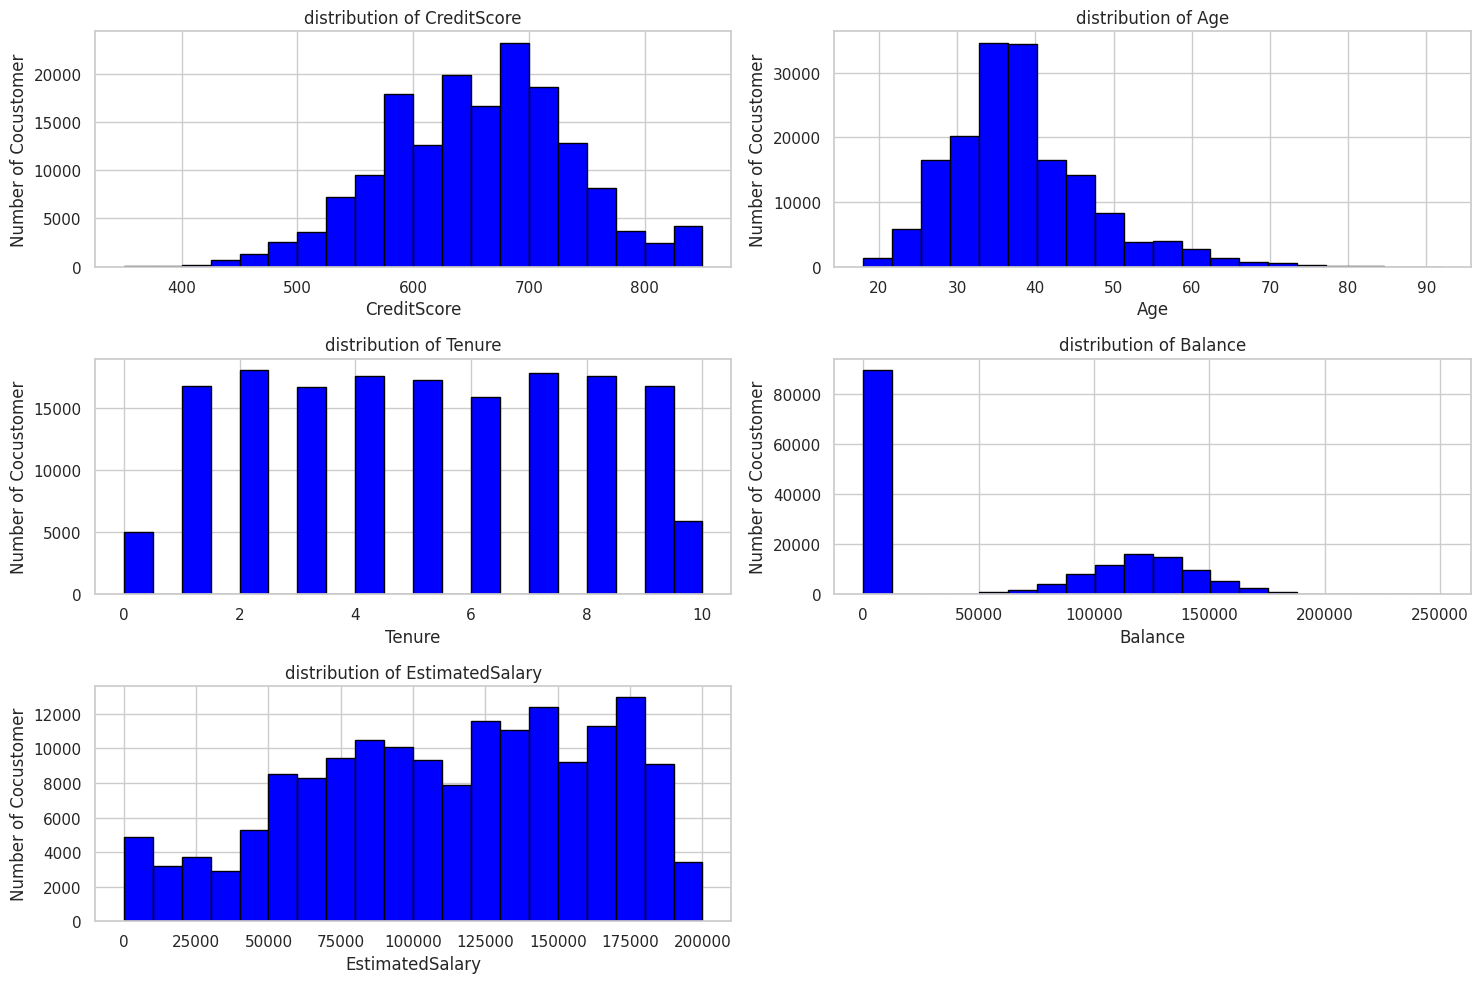

In [36]:
columns_histogram_plot = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
plt.figure(figsize=(15,10))
# loop through the number of rows and data frame columns
for i, columns in enumerate(columns_histogram_plot):
    plt.subplot(3,2,i+1)
    df[columns].hist(bins = 20,color = 'blue', edgecolor ='black')
    plt.title(f'distribution of {columns}')
    plt.xlabel(columns)
    plt.ylabel('Number of Cocustomer')
# Prevents overlap of plots
plt.tight_layout()
plt.show()

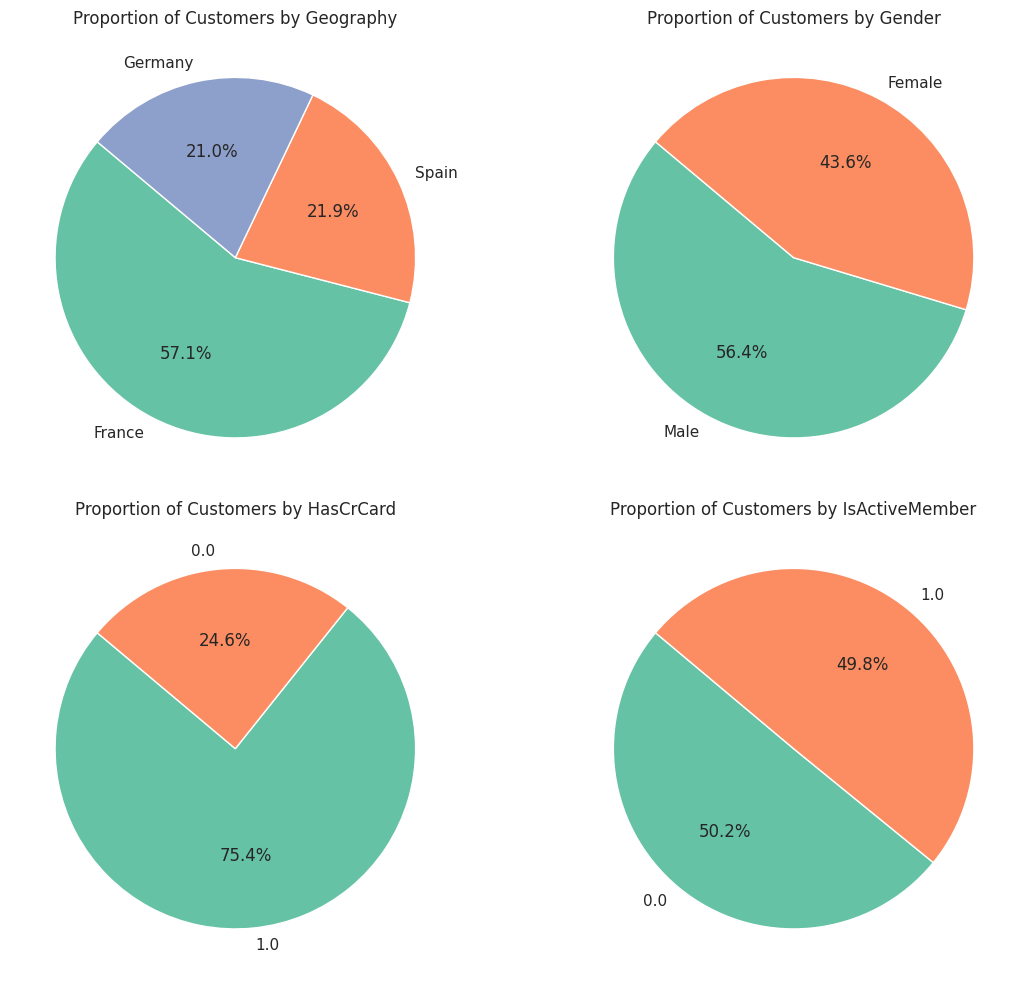

In [37]:
columns_pie_plot = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
for ax, column in zip(axes.flatten(), columns_pie_plot):
    category_counts = df[column].value_counts()
    ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Proportion of Customers by {column}')
# Prevents overlap of plots
plt.tight_layout()
plt.show()

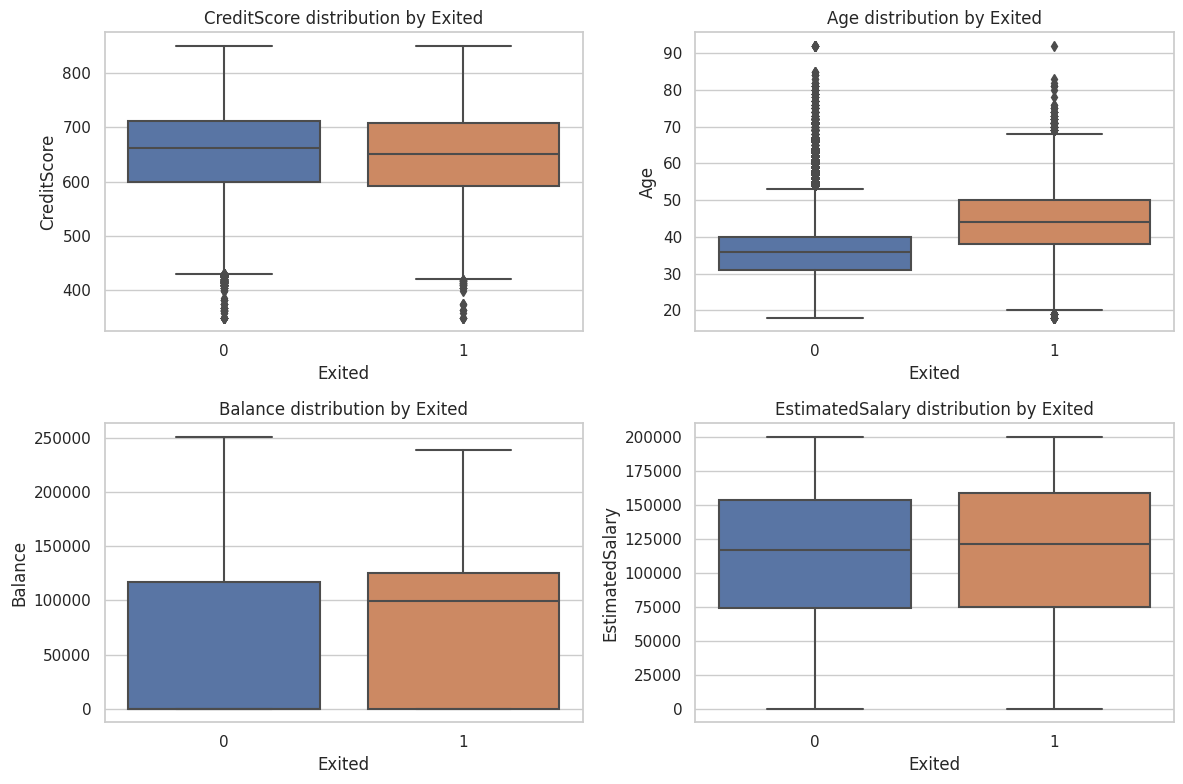

In [38]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
# Create box plots for the specified numerical columns stratified by 'Exited'
plt.figure(figsize=(12, 8))
for i, column in enumerate(['CreditScore', 'Age', 'Balance', 'EstimatedSalary'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Exited', y=column, data=df)
    plt.title(f'{column} distribution by Exited')
    plt.xlabel('Exited')
    plt.ylabel(column)
# Prevents overlap of plots
plt.tight_layout()
plt.show()

<a id="4"></a>
# <b>4 <span style='color:#94D4F6'>|</span> Preprocessing</b>

In [ ]:
## utils/functions

# Unique Value
def uniqueValue(columns_name,df):
    return df[columns_name].unique()
# Null value
def DropNullValue(data):
    data = data.dropna()
    return data

# Replace missing values with mean
df['Geography'].fillna(df['Geography'].mean(), inplace=True)
                            
# Concatenate the datasets vertically
df = pd.concat(objs=[df, od]).reset_index(drop=True)

# drop null value
df = DropNullValue(df)
test = DropNullValue(test)

### Encode Categorical Variables to Numerical

In [ ]:
Geograpy_unique = uniqueValue('Geography',df)
Gender_unique = uniqueValue('Gender',df)
print(Geograpy_unique)
print(Gender_unique)

In [ ]:
Geograpy_unique = uniqueValue('Geography',test)
Gender_unique = uniqueValue('Gender',test)
print(Geograpy_unique)
print(Gender_unique)

In [ ]:
cate_features = ['Geography', 'Gender']
# Geography
df['Geography'] = df['Geography'].map({
    'France' : 0,
    'Spain': 1,
    'Germany' : 2,
}).astype('int')

# Gender
df['Gender'] = df['Gender'].map({
    'Male' : 0,
    'Female' : 1,
}).astype('int')

test['Geography'] = test['Geography'].map({
    'France' : 0,
    'Spain': 1,
    'Germany' : 2,
}).astype('int')

# Gender
test['Gender'] = test['Gender'].map({
    'Male' : 0,
    'Female' : 1,
}).astype('int')

In [ ]:
df

### Detect Outliers

In [ ]:
tmp_df = df.copy()

# Calculate the mean and standard deviation for each column
means = tmp_df[num_col].mean()
std_devs = tmp_df[num_col].std()

# Define a threshold for what you consider to be an outlier, typically 3 standard deviations from the mean
n_stds = 6
thresholds = n_stds * std_devs

# Detect outliers
outliers = (np.abs(tmp_df[num_col] - means) > thresholds).any(axis=1)
print(f"Detected {sum(outliers)} that are more than {n_stds} SDs away from mean...")

# Remove Outlier
outliers_df = tmp_df[outliers]
print(f"Train data shape BEFORE outlier removal: {df.shape}")
df = tmp_df[~outliers].reset_index(drop=True)
print()
print(f"Train data shape AFTER outlier removal: {df.shape}")

<a id="6"></a>
## Spliting The Dataset to Train and Test

In [ ]:
df.columns

In [ ]:
y_df = df['Exited']
train_df = df.drop('Exited',axis = 1)

In [ ]:
test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df,y_df, test_size=0.2, shuffle=True, random_state=42)

<a id="7"></a>
# <b>4 <span style='color:#94D4F6'>|</span> Modeling</b>

In [37]:
init_models = {
    'xgb' : XGBClassifier(),
    'lgbmC' : LGBMClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(),
}

In [38]:
R2 = []
models_names = []
for i,(key,model) in enumerate(init_models.items()):
    model.fit(X_train,y_train)
    models_names.append(key)
    R2.append(np.mean(cross_val_score(model,X_train,y_train,cv=5)))
models_scores = pd.DataFrame({'model name':models_names,'R2 score':R2})
models_scores.head(7)

Learning rate set to 0.084987
0:	learn: 0.6163610	total: 31.1ms	remaining: 31.1s
1:	learn: 0.5552024	total: 61.6ms	remaining: 30.7s
2:	learn: 0.5080302	total: 84.6ms	remaining: 28.1s
3:	learn: 0.4725921	total: 108ms	remaining: 26.8s
4:	learn: 0.4453984	total: 132ms	remaining: 26.3s
5:	learn: 0.4230028	total: 159ms	remaining: 26.4s
6:	learn: 0.4057575	total: 184ms	remaining: 26.1s
7:	learn: 0.3921299	total: 217ms	remaining: 26.9s
8:	learn: 0.3812614	total: 242ms	remaining: 26.7s
9:	learn: 0.3719241	total: 265ms	remaining: 26.2s
10:	learn: 0.3643716	total: 287ms	remaining: 25.8s
11:	learn: 0.3580532	total: 310ms	remaining: 25.5s
12:	learn: 0.3534136	total: 332ms	remaining: 25.2s
13:	learn: 0.3489002	total: 354ms	remaining: 25s
14:	learn: 0.3459024	total: 375ms	remaining: 24.6s
15:	learn: 0.3429358	total: 398ms	remaining: 24.4s
16:	learn: 0.3409809	total: 420ms	remaining: 24.3s
17:	learn: 0.3386101	total: 444ms	remaining: 24.2s
18:	learn: 0.3366958	total: 467ms	remaining: 24.1s
19:	learn:

,model name,R2 score
0,xgb,0.862286
1,lgbmC,0.864322
2,Gradient Boosting,0.863350
3,CatBoost,0.864172
4,LightGBM,0.864322


/tmp/ipykernel_142/303085194.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70)


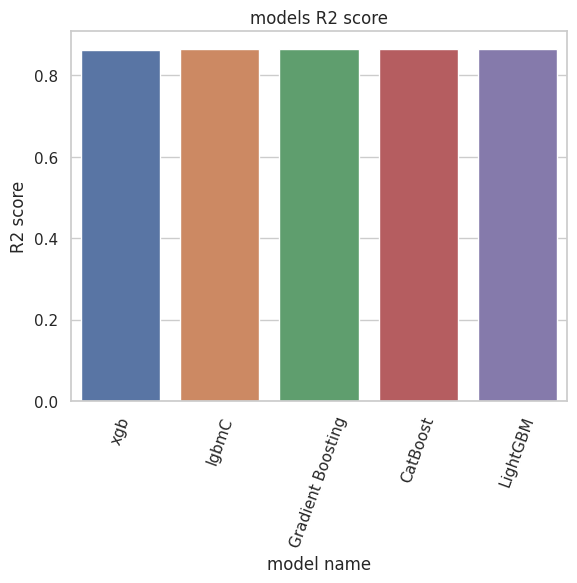

In [40]:
fig, ax = plt.subplots()
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
ax.set_title("models R2 score")
sns.barplot(data=models_scores, x='model name', y="R2 score")
plt.show()

In [41]:
lgbmC = LGBMClassifier()
lgbmC.fit(X_train,y_train)

LGBMClassifier()

In [42]:
y_pred = lgbmC.predict(X_test)

In [43]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8676722660267397


<a id="8"></a>
# <b>5 <span style='color:#94D4F6'>|</span> Evaluation</b>

In [44]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[26322,  1343],
       [ 3289,  4050]])

In [45]:
def plot_confusion_matrix(confusion_matrix, classes):

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show the plot
    plt.show()

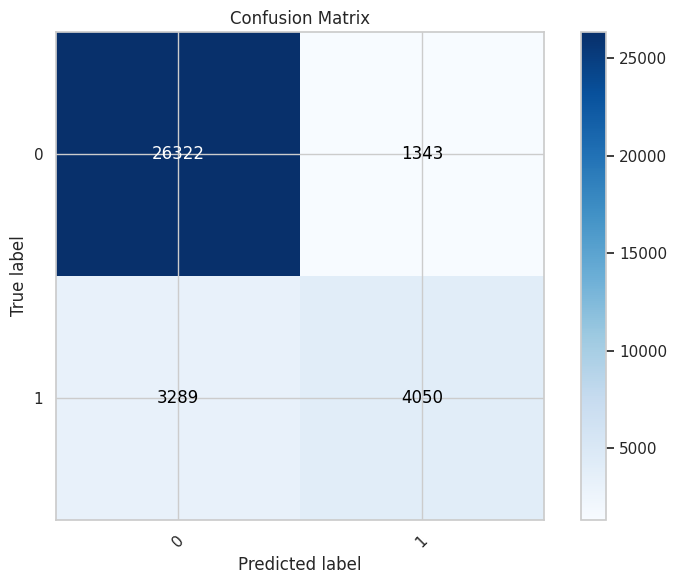

In [48]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=['0','1'])
plt.show()

<a id="9"></a>
# <b>6 <span style='color:#94D4F6'>|</span> Prediction</b>

In [53]:
lgbmC.fit(train_df, y_df)

LGBMClassifier()

In [82]:
predict = lgbmC.predict(test)

ValueError: Number of features of the model must match the input. Model n_features_ is 11 and input n_features is 12

0         165034
1         165035
2         165036
3         165037
4         165038
           ...  
110018    275052
110019    275053
110020    275054
110021    275055
110022    275056
Name: id, Length: 110023, dtype: int64